# HDD 추천 모델

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import torch
import pandas as pd
import os
import seaborn as sns
from tqdm import tqdm

- 사용자의 HDD 선택 기준은 아래와 같다.
    - 가격
    - 용량
    - 속도
    - 사용 용도(컴퓨터가 켜져 있는 시간, 쓰기 정도, 읽기 정도)
- 자체 구축한 실사용 데이터 기반 DB를 이용하여 사용자가 원하는 HDD 스펙을 입력할 수 있도록 한다.
    - 예를 들어 가격은 10만원 이하였으면 좋겠고, 용량은 적어도 1TB, 속도는 최소 100m/s가 나왔으면 좋겠다. 데이터 백업용으로 사용할 것이다(백업용 디스크는 켜져 있는 시간이 작을 것이고, 쓰기량은 많고, 읽기량은 적을 것).
- 사용 용도는 다음과 같이 정리해볼 수 있다.
    - 일단, 사용자의 패턴(가정용, 연구실용, 데이터센터용)을 따지지 말고, 정량적으로 얼마나 사용할 지를 입력받자.
- 그러면 다음과 같은 모델을 생각해볼 수 있을 것이다.
    - 추천 모델 : 가격, 용량, 속도에 대해 범위 탐색을 진행하여 하드디스크를 추천해주는 모델
    - 비추천 모델 : 실사용 데이터(HDD가 켜져 있는 시간, 쓰기 정도, 읽기 정도)에 따른 HDD 실패율을 분석하여 가장 실패 확률이 높다고 판단되는 HDD를 선별해주는 모델, 딥러닝을 이용할지 아니면 확률밀도함수를 구해 앙상블을 할지 "고민" 중
- 위의 두 모델을 앙상블하여 추천된 모델과 비추천 모델을 둘 다 제시하여 사용자가 HDD를 선택할 수 있는 폭을 넓혀준다.

## Load Dataset

In [3]:
path_parent = './data/2022'
path_files = os.listdir(path_parent)
path_files.sort()

print(path_files[0], len(path_files))

2022-01-01.csv 365


### HDD Specification 불러오기

In [4]:
hdd_spec_df = pd.read_csv('./hdd-model-specs-2022.csv')
hdd_spec_df

Model Type          Company     Price  Capacity     RPM  \
0         CT250MX500SSD1  SSD          Crucial   37920.0      0.25     NaN   
1            DELLBOSS VD  SSD             DELL       NaN       NaN     NaN   
2   HGST HDS5C4040ALE630  HDD             HGST  455120.0      4.00  5700.0   
3   HGST HDS724040ALE640  HDD             HGST  146134.0      4.00  7200.0   
4   HGST HMS5C4040ALE640  HDD             HGST       NaN      4.00  5700.0   
..                   ...  ...              ...       ...       ...     ...   
70          WDC WD60EFRX  HDD  Western Digital  455000.0      6.00  5400.0   
71       WDC WDS250G2B0A  SSD  Western Digital   38370.0      0.25     NaN   
72   WDC WUH721414ALE6L4  HDD  Western Digital  558990.0     14.00  7200.0   
73   WDC WUH721816ALE6L0  HDD  Western Digital       NaN     16.00  7200.0   
74   WDC WUH721816ALE6L4  HDD  Western Digital  608970.0     16.00  7200.0   

    Buffer   Read  Write Method  Warranty  Thickness  
0      NaN  560.0  510.0    NaN       5.0        7.0  
1      NaN    NaN    NaN    NaN       NaN        NaN  
2     32.0    NaN    NaN    NaN       NaN       26.1  
3     64.0    NaN    NaN    NaN       2.0       26.1  
4     64.0    NaN    NaN    NaN       3.0       26.1  
..     ...    ...    ...    ...       ...        ...  
70    64.0  175.0  175.0    CMR       3.0       26.1  
71     NaN  550.0  525.0    NaN       5.0        7.0  
72   512.0  267.0  267.0    CMR       5.0       26.1  
73   512.0    NaN    NaN    NaN       NaN       26.1  
74   512.0  262.0  262.0    CMR       5.0       26.1  

[75 rows x 12 columns]

### Feature 선정 기준
- 대부분의 하드디스크에 존재하는 S.M.A.R.T. 속성
- 실사용과 관련된 S.M.A.R.T. 속성 (재할당된 섹터 수 또는 복구 불가한 섹터 수 등은 failure 속성에 이미 선반영 되어있으므로 제외)
- SSD는 데이터에서 제외
- 선정된 Feature에 결측치가 존재하는 데이터는 제외

### Selected Features
- 009: Power-On Hours(RAW, 안정성 지표)
  - 실제 HDD 동작 시간
- 012: Power Cycle Count(RAW, 안정성 지표)
  - HDD를 켜고 끈 횟수
- 241: Total LBAs Written
  - 섹터 크기가 512 bytes라고 가정했을 때 총 기록한 데이터의 양을 알 수 있음
- 242: Total LBAs Read
  - 섹터 크기가 512 bytes라고 가정했을 때 총 읽은 데이터의 양을 알 수 있음
- Price
- Capacity
- RPM
  - 읽기 및 쓰기 속도에 선형적으로 양의 상관관계를 가짐

In [5]:
hdd_feature_pkl_path = './temp/' + f"hdd_feature_{path_parent.split('/')[-1]}.pkl"

if os.path.exists(hdd_feature_pkl_path):
    # load from pickle
    hdd_feature_df = pd.read_pickle(hdd_feature_pkl_path)
    print('cached hdd feature loaded!')
else:
    # create new dataframe
    hdd_feature_df = pd.DataFrame()
    print('there is no cached hdd feature, create new dataframe!')

    for path_file in tqdm(path_files):
        # read csv
        _temp_df = pd.read_csv(path_parent + '/' + path_file)
        # select columns(model, failure, smart_9_raw, smart_12_raw, smart_241_raw, smart_242_raw)
        _temp_df = _temp_df[[
            'model', 'failure', 'smart_9_raw', 'smart_12_raw', 'smart_241_raw', 'smart_242_raw'
        ]]
        hdd_feature_df = pd.concat([hdd_feature_df, _temp_df], ignore_index=True)

    # save(cache) to pickle
    hdd_feature_df.to_pickle(hdd_feature_pkl_path)


cached hdd feature loaded!


In [6]:
hdd_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80357762 entries, 0 to 80357761
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   model          object 
 1   failure        int64  
 2   smart_9_raw    float64
 3   smart_12_raw   float64
 4   smart_241_raw  float64
 5   smart_242_raw  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ GB


In [7]:
hdd_feature_df

model  failure  smart_9_raw  smart_12_raw  \
0               ST14000NM001G        0       9937.0          12.0   
1               ST12000NM001G        0      13174.0           1.0   
2                ST8000NM0055        0      12781.0           7.0   
3                ST8000NM0055        0      40970.0           8.0   
4         TOSHIBA MG07ACA14TA        0       6104.0           2.0   
...                       ...      ...          ...           ...   
80357757  WDC WUH721816ALE6L4        0       1316.0          20.0   
80357758  WDC WUH721816ALE6L4        0       1321.0          20.0   
80357759  WDC WUH721816ALE6L4        0       1317.0          20.0   
80357760  WDC WUH721816ALE6L4        0       1323.0          20.0   
80357761  WDC WUH721816ALE6L4        0       1308.0          20.0   

          smart_241_raw  smart_242_raw  
0          7.553940e+10   1.393253e+11  
1          7.024093e+10   1.643633e+11  
2          2.530152e+10   1.738541e+11  
3          8.320974e+10   3.021204e+11  
4                   NaN            NaN  
...                 ...            ...  
80357757            NaN            NaN  
80357758            NaN            NaN  
80357759            NaN            NaN  
80357760            NaN            NaN  
80357761            NaN            NaN  

[80357762 rows x 6 columns]

## HDD Feature 분석

- 정말로 아래의 features가 하드디스크의 실패율을 좌우하는가?
    1. 009: Power-On Hours
    2. 241: Total LBAs Written
    3. 242: Total LBAs Read
- [Building structured multi-plot grids](https://seaborn.pydata.org/tutorial/axis_grids.html)

### Power-On Hours

In [28]:
hdd_power_on_hours_df = hdd_feature_df[['model', 'failure', 'smart_9_raw']].dropna()

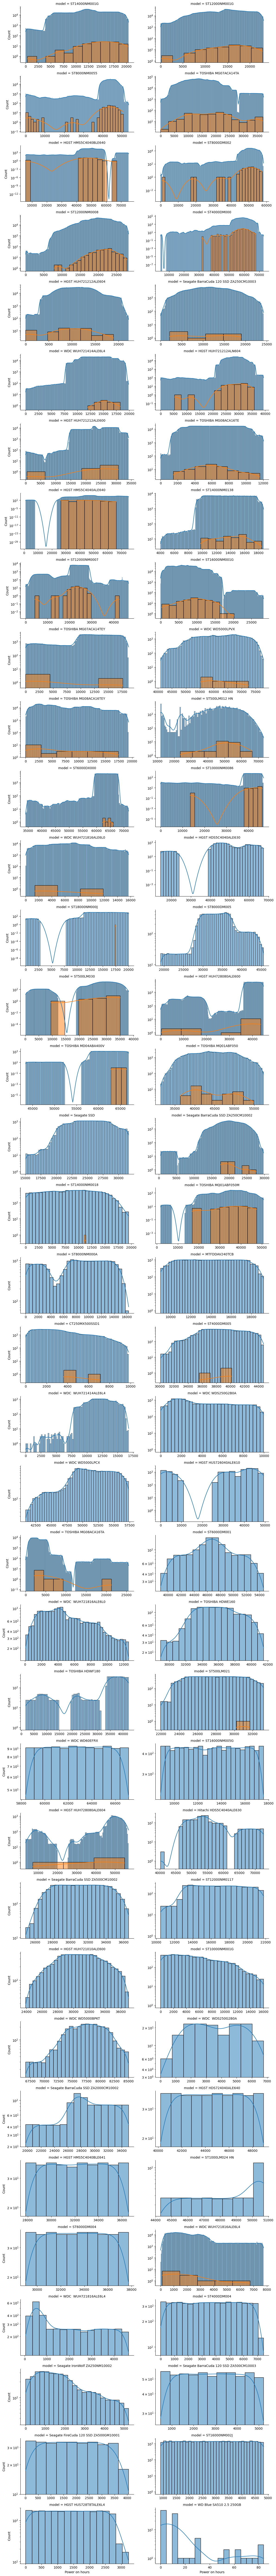

In [44]:
g = sns.FacetGrid(hdd_power_on_hours_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_9_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Power on hours', 'Count')

# save to png
g.savefig('./output/' + f"hdd_power_on_hours_{path_parent.split('/')[-1]}.png")

### Total LBAs Written

In [30]:
hdd_written_df = hdd_feature_df[['model', 'failure', 'smart_241_raw']].dropna()

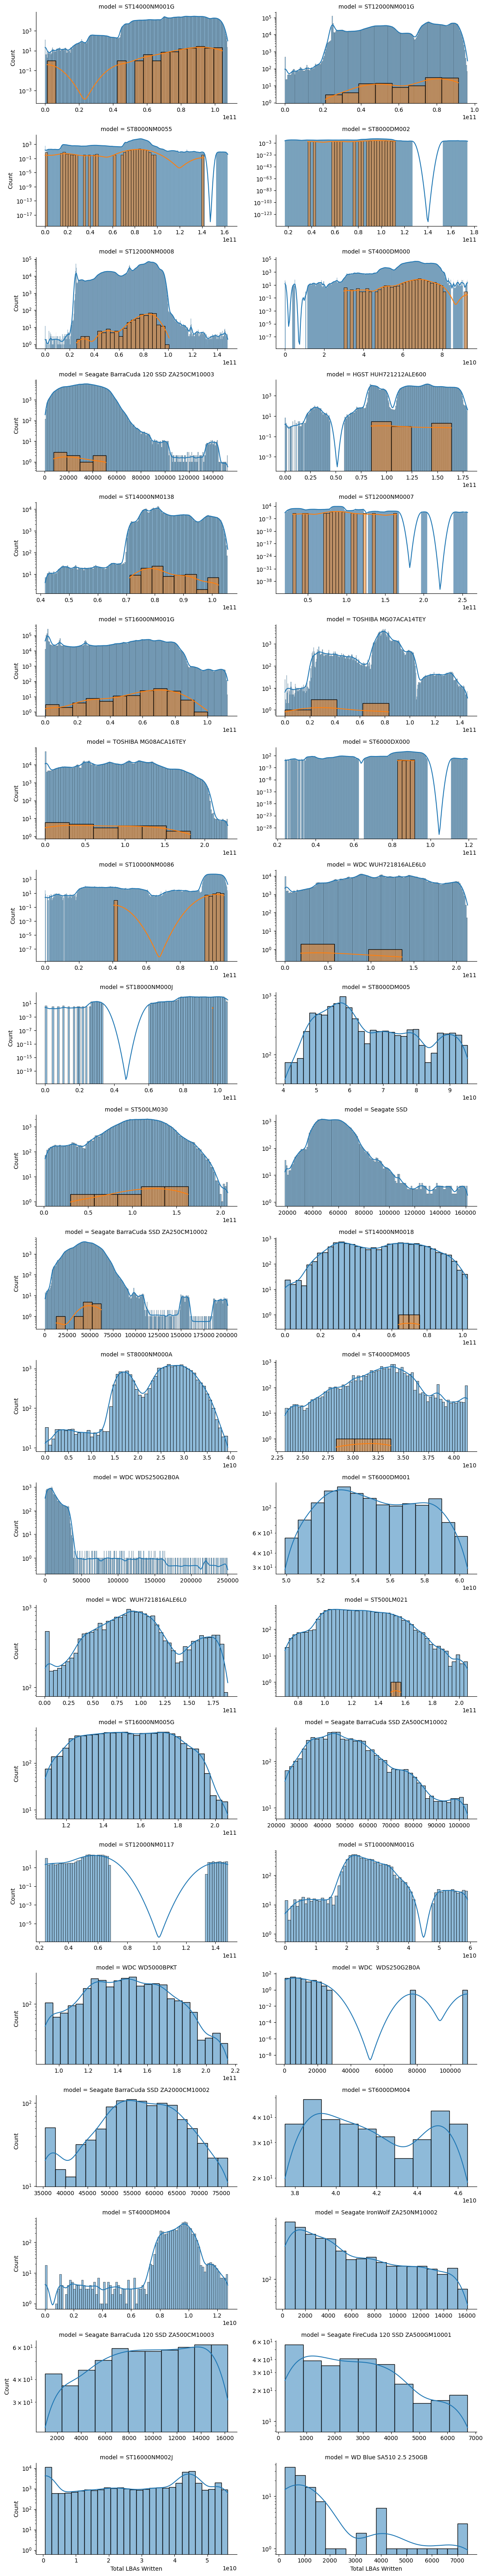

In [45]:
g = sns.FacetGrid(hdd_written_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_241_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Total LBAs Written', 'Count')

# save to png
g.savefig('./output/' + f"hdd_written_{path_parent.split('/')[-1]}.png")

### Total LBAs Read

In [ ]:
hdd_read_df = hdd_feature_df[['model', 'failure', 'smart_242_raw']].dropna()

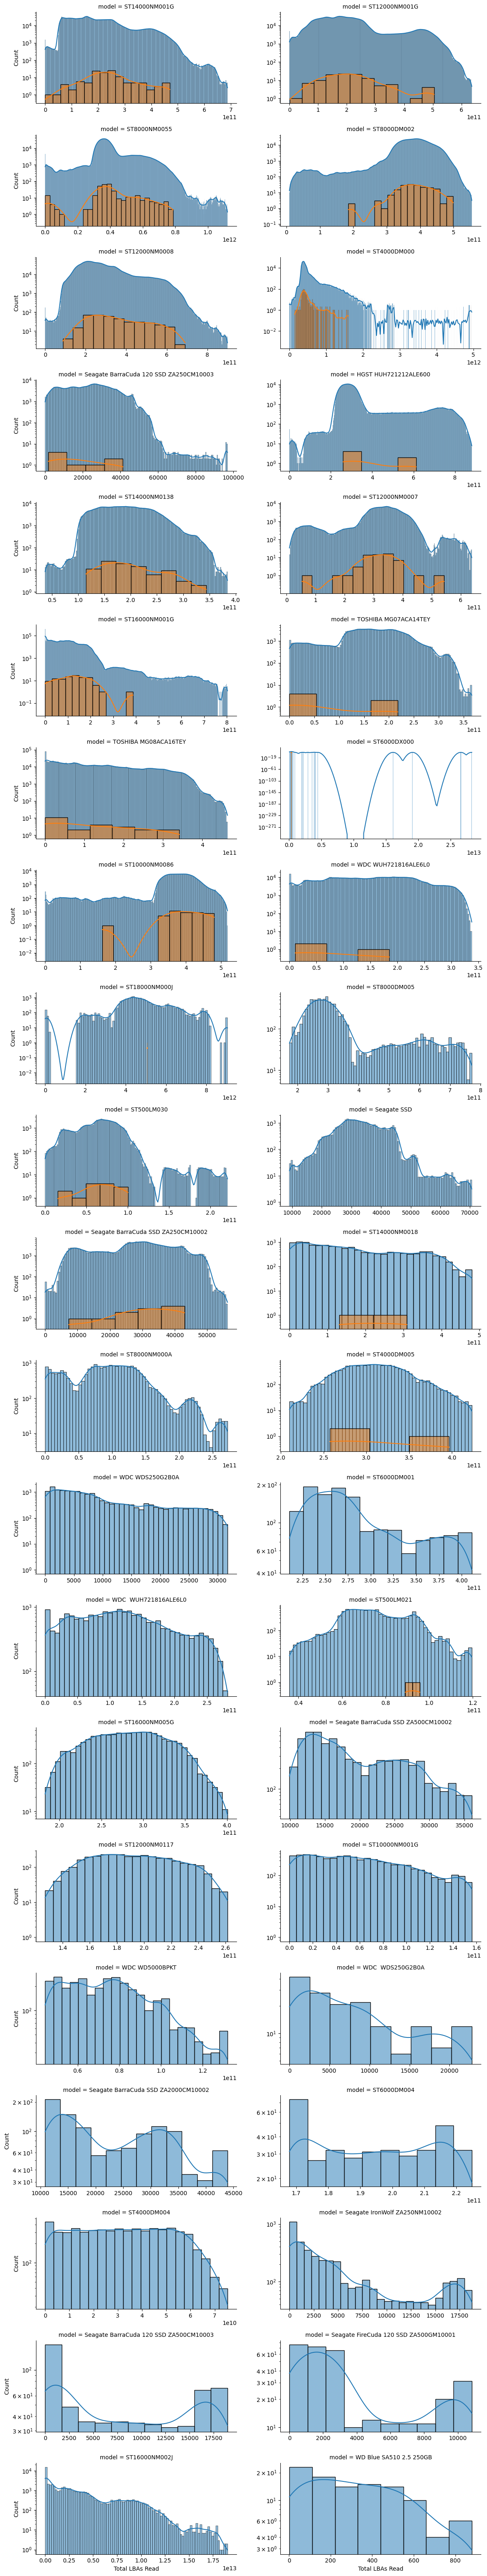

In [46]:
g = sns.FacetGrid(hdd_read_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_242_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Total LBAs Read', 'Count')

# save to png
g.savefig('./output/' + f"hdd_read_{path_parent.split('/')[-1]}.png")

- 각 feature들은 HDD의 실패에 관여하지 않음을 시각적으로 확인할 수 있다.
- 둘 다 비슷한 분포(모수가 비슷함)를 보인다.
- 이는 곧 각 feature들이 정말로 failure에 영향을 미치는지 알 수 없다.
- 그러므로, 참고 지표로만 사용해야 할 것이다.